In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models
import torchvision.transforms as transforms
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [2]:
train_dir = '/floyd/input/f1_cars/TRAIN'
test_dir = '/floyd/input/f1_cars/TEST'

classes = sorted(os.listdir(train_dir))

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.RandomResizedCrop(448),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

print("Number of train images: ", (len(train_data)))
print("Number of test images: ", len(test_data))

Number of train images:  669
Number of test images:  163


In [4]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

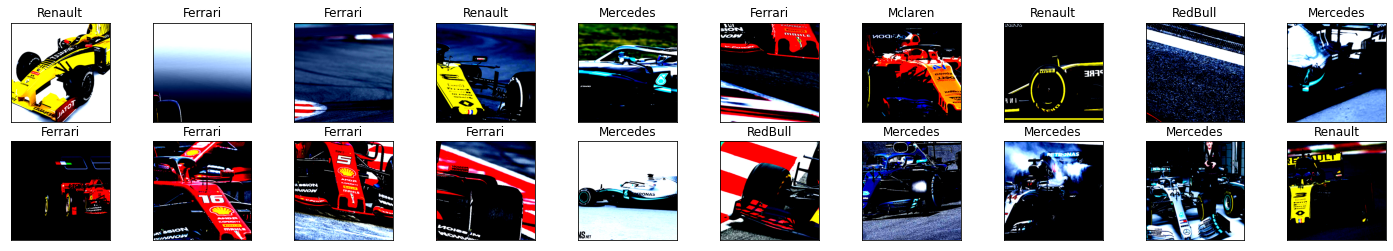

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.numpy() 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [6]:
# download pretrained model, vgg16

vgg16 = models.vgg16(pretrained=True)

# check model's architecture
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [7]:
# now we need to freeze the model's parameters, so it acts as a fixed feature extractor and then
# we'll replace last linear layer so that it'll have only 2 out_features -> the number of our classes

for param in vgg16.features.parameters():
    param.requires_grad = False

# access the last layer in the net
n_inputs = vgg16.classifier[6].in_features

# create new layer to have original number of in_features and out_features equal to number of classes we have in our data
last_layer = nn.Linear(n_inputs, len(classes))

# overwrite last layer with our layer
vgg16.classifier[6] = last_layer

# check if it's correct
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
#final thing before training is to specify loss function, optimzier and learning rate

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [11]:
# if GPU is available, move the model to GPU
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    vgg16.cuda()

In [14]:
#vgg16.cuda()

In [12]:
#train the network

n_epochs = 15

for epoch in range(1, n_epochs + 1):
    
    #vgg16 by default is in train() mode so we don't have to use this method here
    
    #keep track of training loss
    train_loss = 0
    
    for batch_i, (data, target) in enumerate(train_loader):
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
           
        optimizer.zero_grad()             #clear the gradients
        output = vgg16(data)              #do the forward pass
        loss = criterion(output, target)  #calculate loss
        loss.backward()                   #do the backward pass
        optimizer.step()                  #perform parameter update
        train_loss += loss.item()         #update training loss
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.5966357290744781


/usr/local/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2, Batch 20 loss: 1.4682740807533263
Epoch 3, Batch 20 loss: 1.3674118161201476
Epoch 4, Batch 20 loss: 1.2674633204936980
Epoch 5, Batch 20 loss: 1.1615630924701690
Epoch 6, Batch 20 loss: 1.0787854313850402
Epoch 7, Batch 20 loss: 1.0012175589799881
Epoch 8, Batch 20 loss: 0.9053927034139633
Epoch 9, Batch 20 loss: 0.8539738476276397
Epoch 10, Batch 20 loss: 0.7894747495651245
Epoch 11, Batch 20 loss: 0.7028379976749420
Epoch 12, Batch 20 loss: 0.7112162709236145
Epoch 13, Batch 20 loss: 0.6197844669222832
Epoch 14, Batch 20 loss: 0.5872021257877350
Epoch 15, Batch 20 loss: 0.5987989261746407


In [13]:
#test the network

test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

vgg16.eval() # now we need to switch to eval mode

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = vgg16(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)  
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    try:
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    except:
        for i in range(3):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1 

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.457999

Test Accuracy of Ferrari: 94% (34/36)
Test Accuracy of Mclaren: 87% (27/31)
Test Accuracy of Mercedes: 91% (31/34)
Test Accuracy of RedBull: 81% (26/32)
Test Accuracy of Renault: 90% (30/33)

Test Accuracy (Overall): 89% (148/166)


In [122]:
#visualize results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

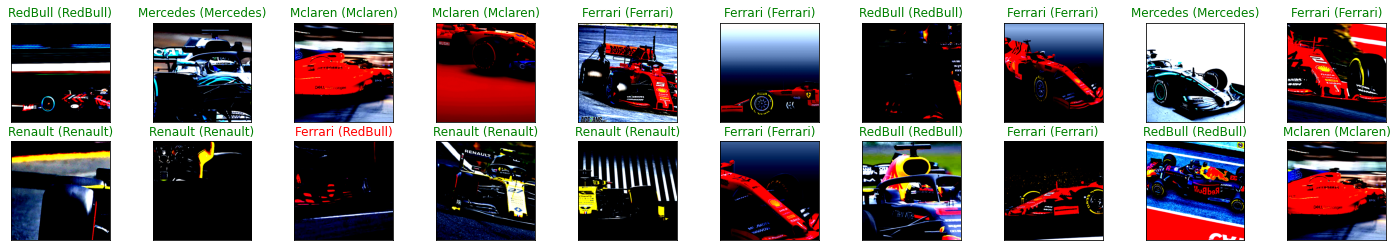

In [123]:
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in range(len(images)):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))